# Uncertainty measures used in the benchmark

As a reminder, we consider two types of uncertainty measures:

- The <span style="color:blue">**aleatoric uncertainty**</span>, that conveys the <span style="color:blue">**ambiguity**</span> intrinsic to the data. In theory, this uncertainty can not be reduced with additional training data.
- The <span style="color:orange">**epistemic uncertainty**</span>, that conveys <span style="color:orange">**novelty**</span> within the data, and can be reduced with additional training data,

## 1. Aleatoric uncertainty

To estimate the aleatoric uncertainty, we will use an approach based on the information theory that we present below.


###  1.1 **Deterministic information gain**


The **deterministic information gain** approach that consist in applying information theory measures on the softmax probability distribution of a single Neural Network. In this benchmark, we use the Shannon Entropy as the utility function.

<img src="./images/aleatoric_approach.jpg" width=80%/>

The **shannon entropy** on the averaged softmax probability distribution over the ensemble is computed as follow:


$ H(z) = -\sum^{N}_{i=1}{p_{i}(z)\log_{2} p_{i}(z)} $

with $z$ a data point in the feature space and $i$ the class index.


## 2. Epistemic uncertainty

To estimate the aleatoric uncertainty, two approaches arise from the literature.

### 2.1 **Deep ensemble**

The **deep ensemble** methods that consist in duplicating the Neural Network in order to estimate the variance of in the predictions probability with an ensemble of softmax probability distributions. With standardized datasets (MNIST), this approach was found to model the best the <span style="color:orange">**epistemic uncertainty**</span>,

<img src="./images/epistemic_approach.jpg" width=80%/>

In this benchmark, we compute the disagreement in the predictions of the ensemble using:
TODO: keep just one?

<!-- - The **variation ratio**, calculated as follow:

$ v(z) = 1 - \frac{f_k}{K}$

with $f_k$ the number of prediction of the modal class, $K$ the size of the model ensemble. -->


- The averaged **standard deviation over the classes** probability:

$ var(z) = \frac{1}{N}\sum^{N}_{i=1}{\underset{k \in ensemble}{std}p^{k}_{i}(z)} $

with $p^{k}_{i}$ the probability of class $i$ from the $k^{th}$ model in the ensembe.


### 2.2 **Density estimation** in the feature space with a deterministic model

The **density estimation** in the feature space with a deterministic model (the embedding). This approach aims at modelling the <span style="color:orange">**epistemic uncertainty**</span> with a smaller computational cost than the deep ensemble technique since it does not require to duplicate the models.

<img src="./images/density_approach.jpg" width=60%/>

In this benchmark, we used three methods to estimate the density of the training data points:

<!-- - The **Gaussian Discriminant Analysis** in which the distribution of each class is modeled as a multivariate gaussian. We compute the distance between unseen data points and the training data points as follows:

$d(z) = \underset{i \in classes}{\min}\sum^{N}_{i=1} \frac{|\mu_{i} - z|^{2}}{\sigma_{i}^{2}}$ 

with $\mu_{i}$ resp. $\sigma_{i}$ the centroïd resp. the variance of the gaussian centered on class $i$. -->

- The **Gaussian Mixture Model**, which assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. We use one component per class. The epistemic uncertainty is calculated using the weighted log probabilities for each sample.

- A **Gaussian Mixture Model per class**, in which we fit one GMM with 5 components per class.

- The **Density estimation** over the entire classes, using a gaussian kernel, a positive function controlled by the bandwidth parameter. Given this kernel form, the density estimate at a point within a group of points is given by:

$\phi_{K}(z) = \sum^{N}_{i=1} K(y- x_{i}; h)$

with: $K(x;h) \propto exp(-\frac{x^{2}}{2h^{2}})$


# Data importation and models declaration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from common.utilities import Data
from common.figures import Figures
from common.metrics import PerformanceMetrics

from common.models import ModelUtilities


In [2]:
filepath = "./datasets/processed_data/mnist_data.pkl"
train, test, uncertain = Data.get_dataset(filepath = filepath)
(z_train, y_train), (z_test, y_test), z_uncertain = Data.dataframe2arrays(train, test, uncertain)

Dataset loaded...
Number of images:  600
Features:  name, class_label, uncertainty_label, group, X_PIL, X_array, X_mobilenet, y_onehot, y, z_ensemble
Labels:  0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
Training set size:  160
Testing set size:  200
Uncertain pool size:  240


# Sanity check: how many training epochs do we need to reach convergence?

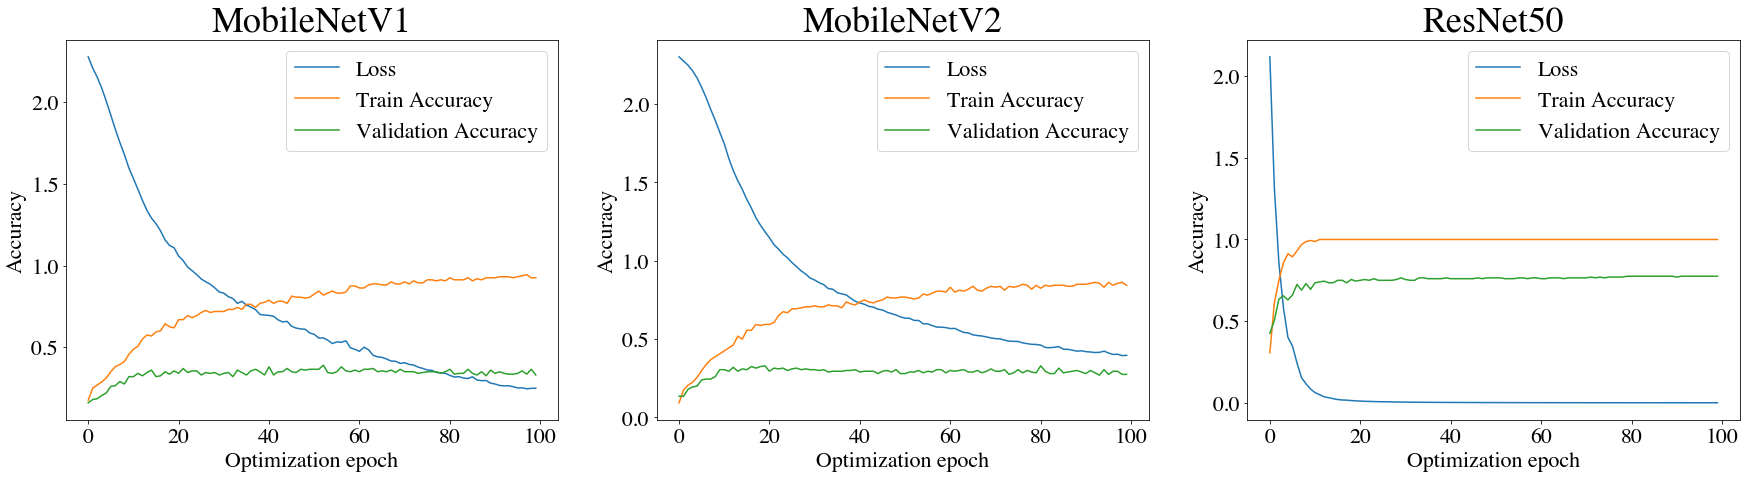

In [3]:
Figures.check_convergence_mlp(z_train, y_train, z_test, y_test, num_classes = 10,  nb_epochs = 100, batch_size = 16)

**Observation**: 
- Convergence is much faster with ResNet50 embedding, which is the embedding with the variance the most spread across principal components.
- The convergence for MobileNetV1 and MobileNetV2 is at least four times longer that with card data.

For reaching fast traininig during the study, we chose 10 epochs.

Here is the model studied in our benchmark:

In [4]:
model_params = ModelUtilities.get_models_param(embeddings = ["MobileNetV1", "MobileNetV2", "ResNet50"],
                nb_mlp = [3],
                architecture = [(64,32)],
                epochs = [10],
                batch_sizes = [16],
                classes = list(range(10))
                )
models = ModelUtilities.get_models(model_params)
models

,embedding,n_tot_MLP,architecture,training_epochs,batch_size,classifier,model
name,,,,,,,
GMM-MobileNetV1,MobileNetV1,0,None,None,None,True,<common.models.GMM object at 0x7fdfc9651520>
GaussianKernel-MobileNetV1,MobileNetV1,0,None,None,None,False,<common.models.GaussianDensity object at 0x7fd...
GMM-MobileNetV2,MobileNetV2,0,None,None,None,True,<common.models.GMM object at 0x7fdfc9651ee0>
GaussianKernel-MobileNetV2,MobileNetV2,0,None,None,None,False,<common.models.GaussianDensity object at 0x7fd...
GMM-ResNet50,ResNet50,0,None,None,None,True,<common.models.GMM object at 0x7fdfc9651040>
GaussianKernel-ResNet50,ResNet50,0,None,None,None,False,<common.models.GaussianDensity object at 0x7fd...
DeepEnsemble-MobileNetV1-epochs=10,MobileNetV1,3,"(64, 32)",10,16,True,<common.models.Ensemble object at 0x7fdfc9651be0>
MLP-MobileNetV1-epochs=10,MobileNetV1,1,"(64, 32)",10,16,True,<common.models.MLP object at 0x7fdfc964f940>
DeepEnsemble-MobileNetV2-epochs=10,MobileNetV2,3,"(64, 32)",10,16,True,<common.models.Ensemble object at 0x7fdfc96291c0>


# Model fitting

Now, we are going to fit our list of models onto our training dataset and compute an accuracy on our test dataset.

In [5]:
ModelUtilities.fit_models(models, z_train, y_train, verbose = False)

In [6]:
models["accuracy"] = PerformanceMetrics.accuracy(models, z_train, y_train, z_test, y_test, verbose = False)
models["accuracy"]

name
GMM-MobileNetV1                       0.095
GaussianKernel-MobileNetV1              NaN
GMM-MobileNetV2                       0.135
GaussianKernel-MobileNetV2              NaN
GMM-ResNet50                          0.145
GaussianKernel-ResNet50                 NaN
DeepEnsemble-MobileNetV1-epochs=10    0.300
MLP-MobileNetV1-epochs=10             0.280
DeepEnsemble-MobileNetV2-epochs=10    0.290
MLP-MobileNetV2-epochs=10             0.245
DeepEnsemble-ResNet50-epochs=10       0.740
MLP-ResNet50-epochs=10                0.710
Name: accuracy, dtype: float64

../common/figures.py:406: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


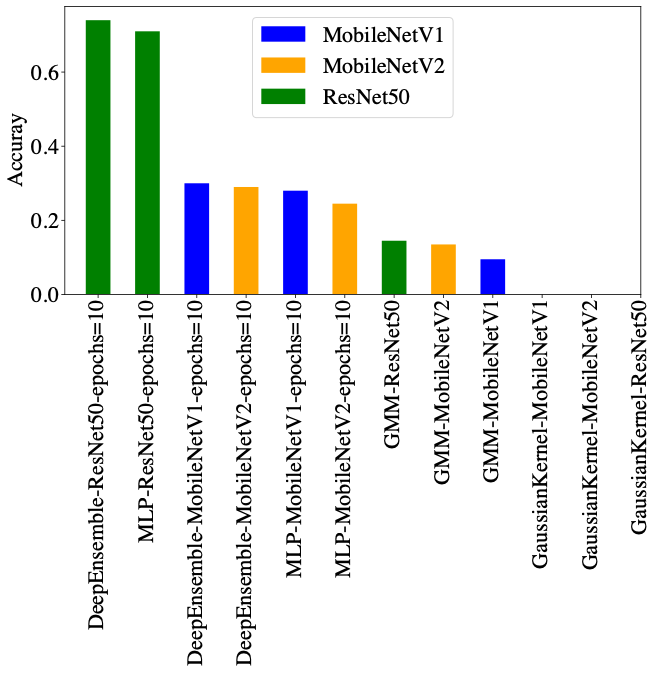

In [7]:
import matplotlib
matplotlib.use('cairo')
import matplotlib.pylab as pylab
import matplotlib.font_manager as fm

font = fm.FontProperties(
        family = 'Gill Sans', fname = '/Library/Fonts/GillSans.ttc')
Figures.accuracies(models, figsize = (10, 5))

**Observation**: 
We see the effect of the embedding and the type of model are crucial to obtain high accuracy. Models using ResNet50 and neural networks work the best.

# Uncertainty on image data points

We now compute uncertainty on our image dataset. The MLP and DeepEnsemble models use two utility function: the Shanon entropy and the averaged standard deviation.

In [8]:
all_data = pd.concat([test, uncertain])

iid = all_data.loc[all_data['uncertainty_label'] == "Classifiable"]
novel = all_data.loc[all_data['uncertainty_label'] == "Novel"]
ambiguous = all_data.loc[all_data['uncertainty_label'] == "Ambiguous"]
(z_novel, y_novel), (z_ambiguous, y_ambiguous), _ = Data.dataframe2arrays(novel, ambiguous, iid)
z_iid  = z_test

In [9]:
values = PerformanceMetrics.uncertainty_classification(models, z_iid, z_uncertain, verbose=False)

We put the uncertainty values in a `pandas.DataFrame` normalize the values.

In [10]:
uncertainty_values = pd.DataFrame({
    "Images": np.concatenate((test["X_PIL"].values, uncertain["X_PIL"].values)),
    "GroundTruth": np.concatenate((test["class_label"].values, uncertain["class_label"].values)),
    "UncertaintyLabel": np.concatenate((test["uncertainty_label"].values, uncertain["uncertainty_label"].values)),
    "Name": np.concatenate((test["name"].values, uncertain["name"].values)),
    })
z_iid = z_test


for model_name in values.keys():
    if type(values[model_name]["Uncertainties"]) == np.ndarray:
        uncertainty_values[model_name] = values[model_name]["Uncertainties"]
    else:
        uncertainty_values[model_name] = None

uncertainty_scaled = Data.normalize(uncertainty_values)

## Correlations between the uncertainty measures

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, 'GMM-MobileNetV1'),
  Text(1.5, 0, 'GaussianKernel-MobileNetV1'),
  Text(2.5, 0, 'DeepEnsemble-MobileNetV1-epochs=10 aleatoric entropy'),
  Text(3.5, 0, 'DeepEnsemble-MobileNetV1-epochs=10 epistemic std'),
  Text(4.5, 0, 'MLP-MobileNetV1-epochs=10 aleatoric entropy'),
  Text(5.5, 0, 'GMM-MobileNetV2'),
  Text(6.5, 0, 'GaussianKernel-MobileNetV2'),
  Text(7.5, 0, 'DeepEnsemble-MobileNetV2-epochs=10 aleatoric entropy'),
  Text(8.5, 0, 'DeepEnsemble-MobileNetV2-epochs=10 epistemic std'),
  Text(9.5, 0, 'MLP-MobileNetV2-epochs=10 aleatoric entropy'),
  Text(10.5, 0, 'GMM-ResNet50'),
  Text(11.5, 0, 'GaussianKernel-ResNet50'),
  Text(12.5, 0, 'DeepEnsemble-ResNet50-epochs=10 aleatoric entropy'),
  Text(13.5, 0, 'DeepEnsemble-ResNet50-epochs=10 epistemic std'),
  Text(14.5, 0, 'MLP-ResNet50-epochs=10 aleatoric entropy')])

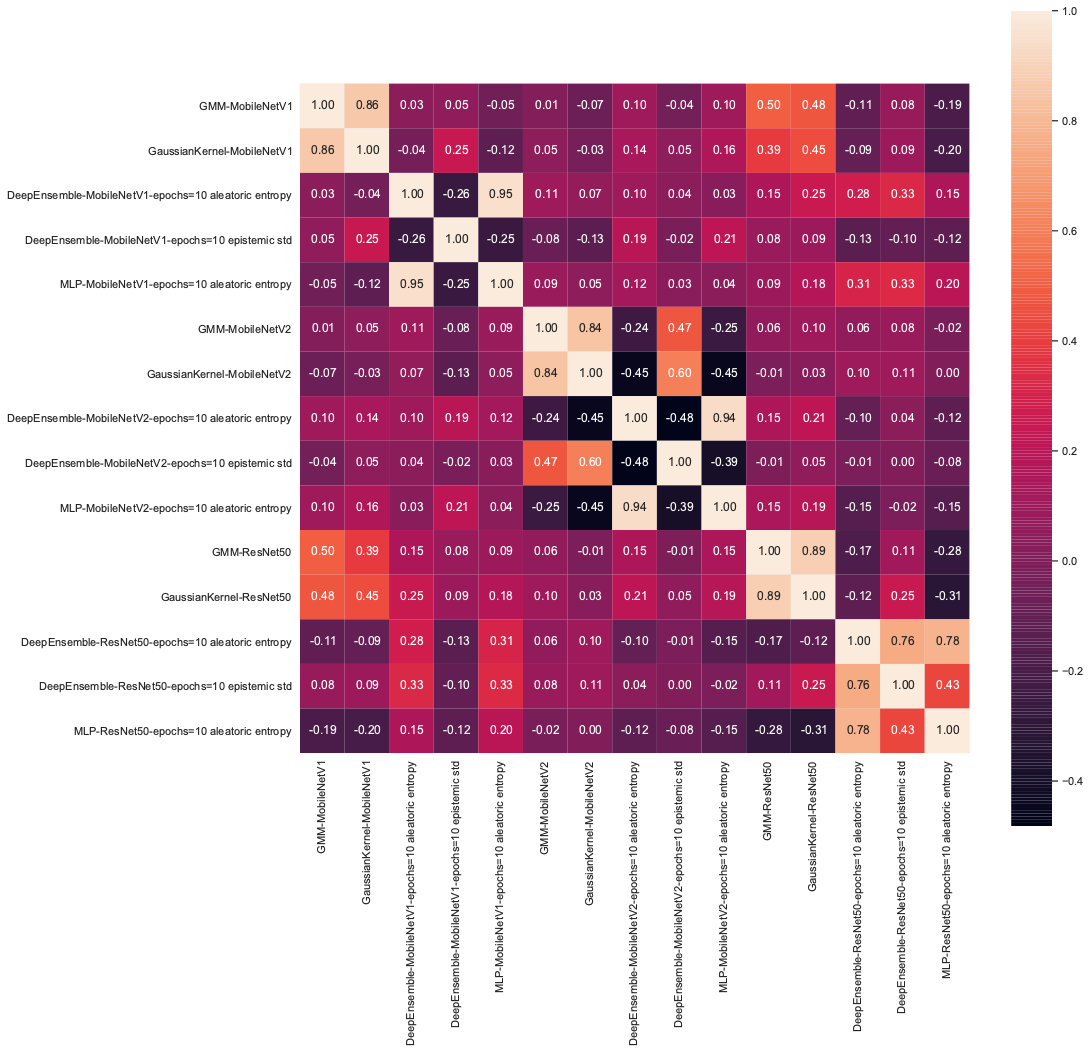

In [11]:
import seaborn as sns; sns.set()
names_embedding = [name for name in uncertainty_scaled.keys() if "MobileNetV1" in name] +  [name for name in uncertainty_scaled.keys() if "MobileNetV2" in name] + [name for name in uncertainty_scaled.keys() if "ResNet50" in name]
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(uncertainty_scaled[names_embedding].corr(), fmt='0.2f', annot=True, square=True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

**Observations**:
- The uncertainty measures does not correlate much in between the different embeddings. This demonstrate the importance of the pre-trained embedding when trying to estimate uncertainty on a given dataset.
- We also observe that neural-network methods are not correlated to density based methods, except for Deep Ennsemble with standard deviation acquisition function with MobileNetV1 and MobileNetV2 (expected behavior). 
- It is surprisinng that Deep Ensemble with epistemic std does not correlate with density-based methods with ResNet50.

## Visualization of uncertain data

We now observe the most uncertainty values for each methods.

In [12]:
for strat_name in uncertainty_scaled.keys():
    if strat_name not in ["GroundTruth", "UncertaintyLabel", "Images"]:
        
        fig = Figures.display_most_uncertain_images(uncertainty_scaled, strat_name)
        fname = open("images/{0}_{1}".format(strat_name, "uncertain.png"), "wb")
        fig.savefig(fname)
        
        fig = Figures.display_most_certain_images(uncertainty_scaled, strat_name)
        fname = open("images/{0}_{1}".format(strat_name, "certain.png"), "wb")
        fig.savefig(fname)

GaussianKernel-ResNet50


../common/figures.py:312: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


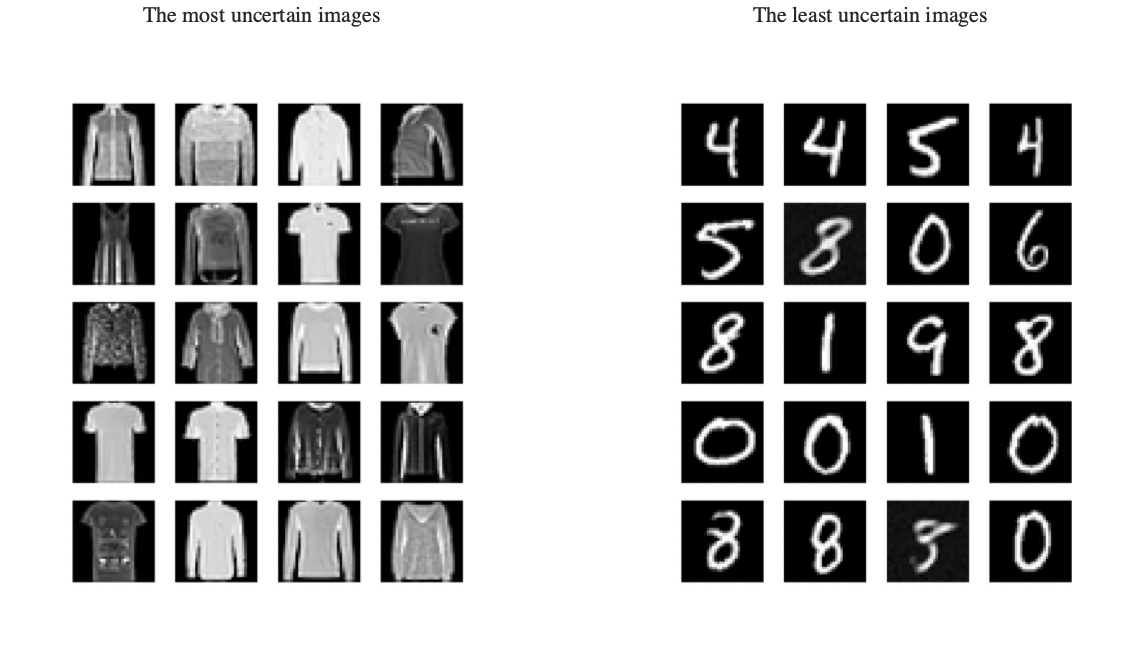

In [13]:
frag = "Kernel"
embedding = "ResNet50"
strat_name = [v for v in names_embedding if (frag in v and embedding in v)][0]
Figures.show_uncertainty(strat_name)

DeepEnsemble-ResNet50-epochs=10 aleatoric entropy


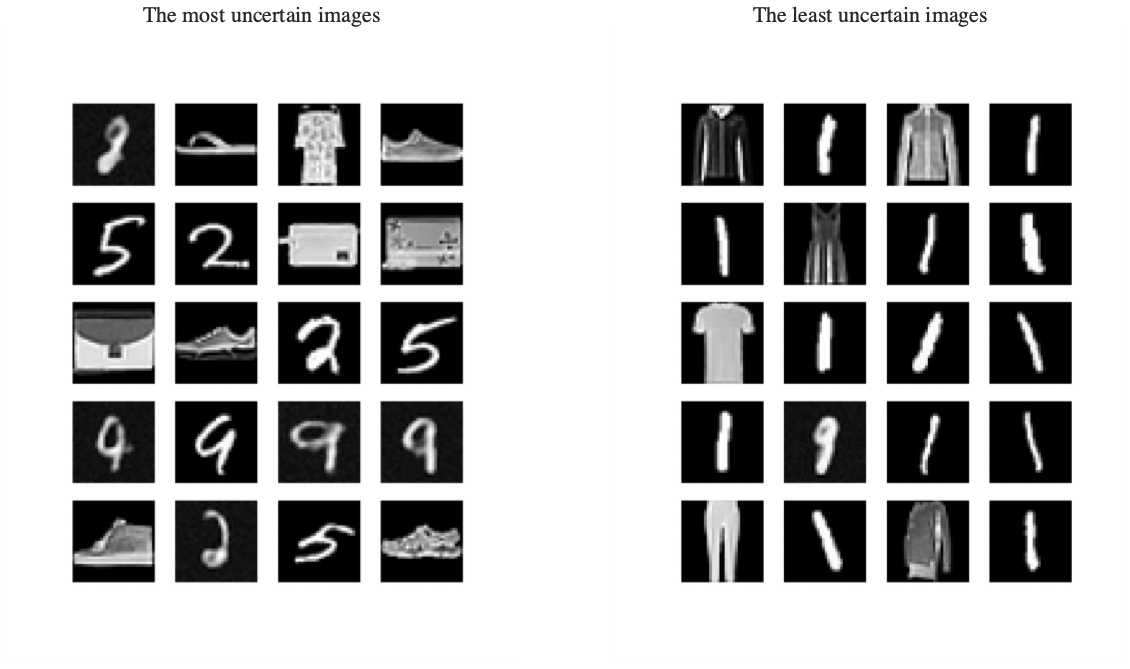

In [14]:
frag = "entropy"
embedding = "ResNet50"
strat_name = [v for v in names_embedding if (frag in v and embedding in v)][0]
Figures.show_uncertainty(strat_name)

**Observation**: It seems that the different techniques are capturing different types of uncertainty.

### Uncertainty separation

We now try to distinguish i.i.d data from novel or ambiguous data using our uncertainity measures.

In [15]:
res_values_OOD = []
for i in range(12):
    print("Itération", i+1, "/10")
    train, test, uncertain = Data.get_dataset(filepath = filepath,  seed = i)
    (z_train, y_train), (z_test, y_test), z_uncertain = Data.dataframe2arrays(train, test, uncertain)
    model_params = ModelUtilities.get_models_param(embeddings = ["MobileNetV1", "MobileNetV2", "ResNet50"],
                nb_mlp = [3],
                architecture = [(64,32)],
                epochs = [10],
                batch_sizes = [16],
                classes = list(range(10))
                )
    models = ModelUtilities.get_models(model_params)
    ModelUtilities.fit_models(models, z_train, y_train, verbose = False)
    z_iid  = z_test
    res_values_OOD.append(PerformanceMetrics.uncertainty_classification(models, z_iid, z_uncertain, verbose = False))

# values_OOD = PerformanceMetrics.uncertainty_classification(models, z_iid, z_uncertain, verbose = True)
# Figures.auroc(PerformanceMetrics.AUROC(values_OOD))

Itération 1 /10
Dataset loaded...
Number of images:  600
Features:  name, class_label, uncertainty_label, group, X_PIL, X_array, X_mobilenet, y_onehot, y, z_ensemble
Labels:  0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
Training set size:  160
Testing set size:  200
Uncertain pool size:  240
Itération 2 /10
Dataset loaded...
Number of images:  600
Features:  name, class_label, uncertainty_label, group, X_PIL, X_array, X_mobilenet, y_onehot, y, z_ensemble
Labels:  0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
Training set size:  160
Testing set size:  200
Uncertain pool size:  240
Itération 3 /10
Dataset loaded...
Number of images:  600
Features:  name, class_label, uncertainty_label, group, X_PIL, X_array, X_mobilenet, y_onehot, y, z_ensemble
Labels:  0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
Training set size:  160
Testing set size:  200
Uncertain pool size:  240
Itération 4 /10
Dataset loaded...
Number of images:  600
Features:  name, class_label, uncerta

../common/figures.py:442: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


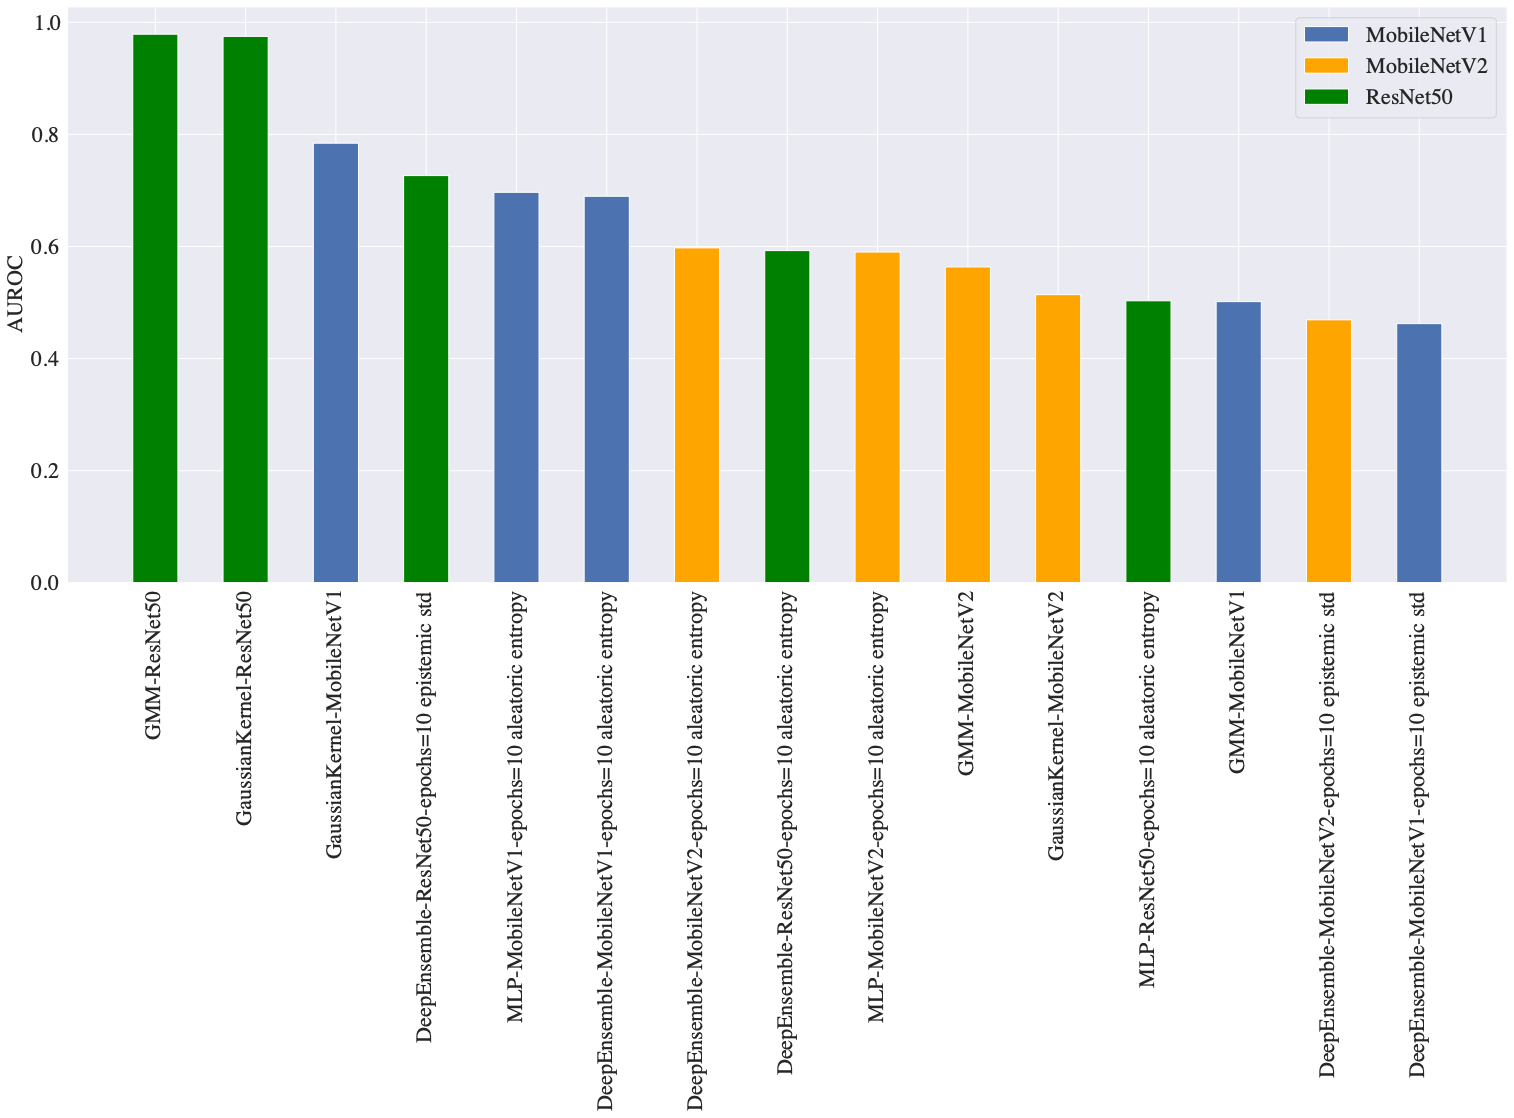

In [16]:
auroc_tmp = {}
auroc_mean = {}
auroc_std = {}
for key in res_values_OOD[0].keys():
    auroc_tmp[key] = []
    for dic in res_values_OOD:
        auroc = PerformanceMetrics.AUROC(dic)
        auroc_tmp[key].append(auroc[key])
    auroc_mean[key] = np.mean(auroc_tmp[key])
    auroc_std[key] = np.std(auroc_tmp[key])

Figures.auroc(auroc_mean)
        
        
    

In [28]:
import pickle
auroc_mnist = {"mean": auroc_mean,
               "std": auroc_std,
               "samples": auro_tmp}
pickle.dump(auroc_mnist, open("auroc_mnist_b.pkl", "wb"))

TypeError: write() argument must be str, not bytes

/Users/teosanchez/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.fig.tight_layout(*args, **kwargs)


<Figure size 1080x1080 with 0 Axes>

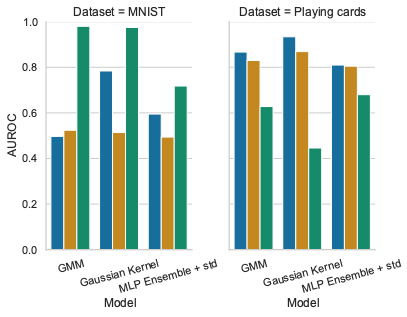

In [81]:
Figures.save_auroc_paper()

In [82]:
values_novel = PerformanceMetrics.uncertainty_classification(models, z_iid, z_novel, verbose = False)

../common/figures.py:442: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


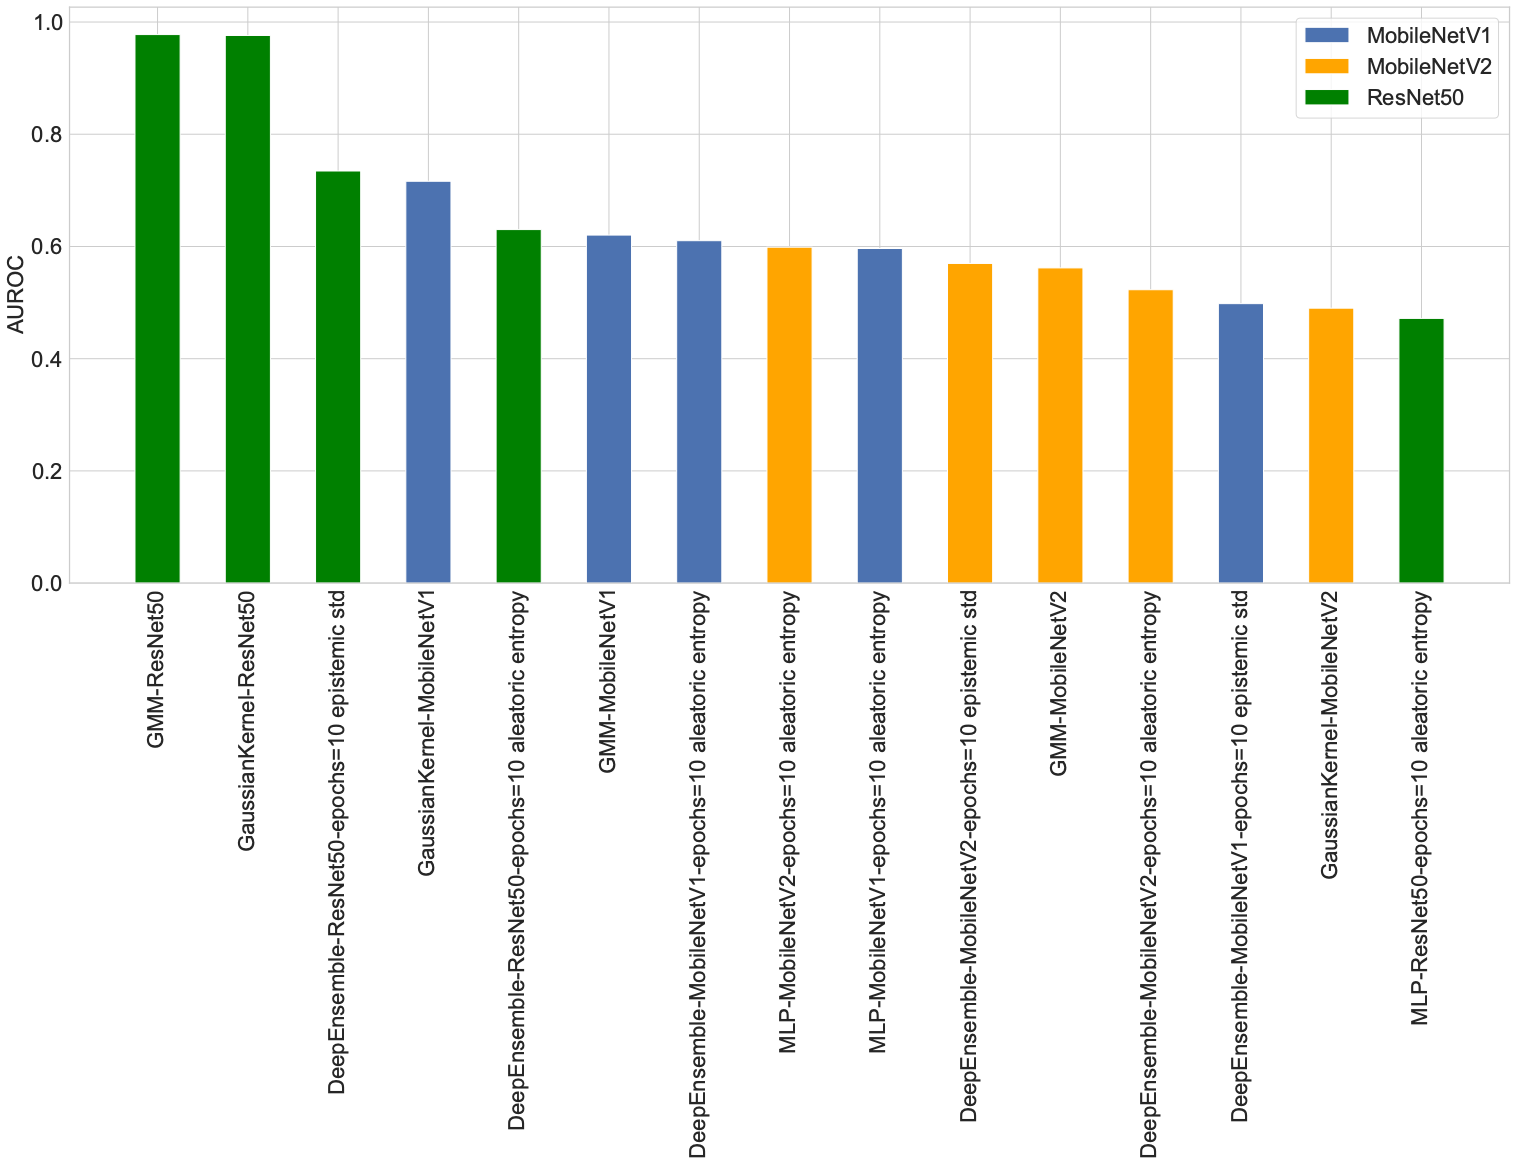

In [83]:
Figures.auroc(PerformanceMetrics.AUROC(values_novel))

**Observations**: It seems that epistemic measures (density based or DE with std) using ResNet50 are the most effective way to identify novel images. Let's have a look to the ROC curves for the ResNet50 embedding:

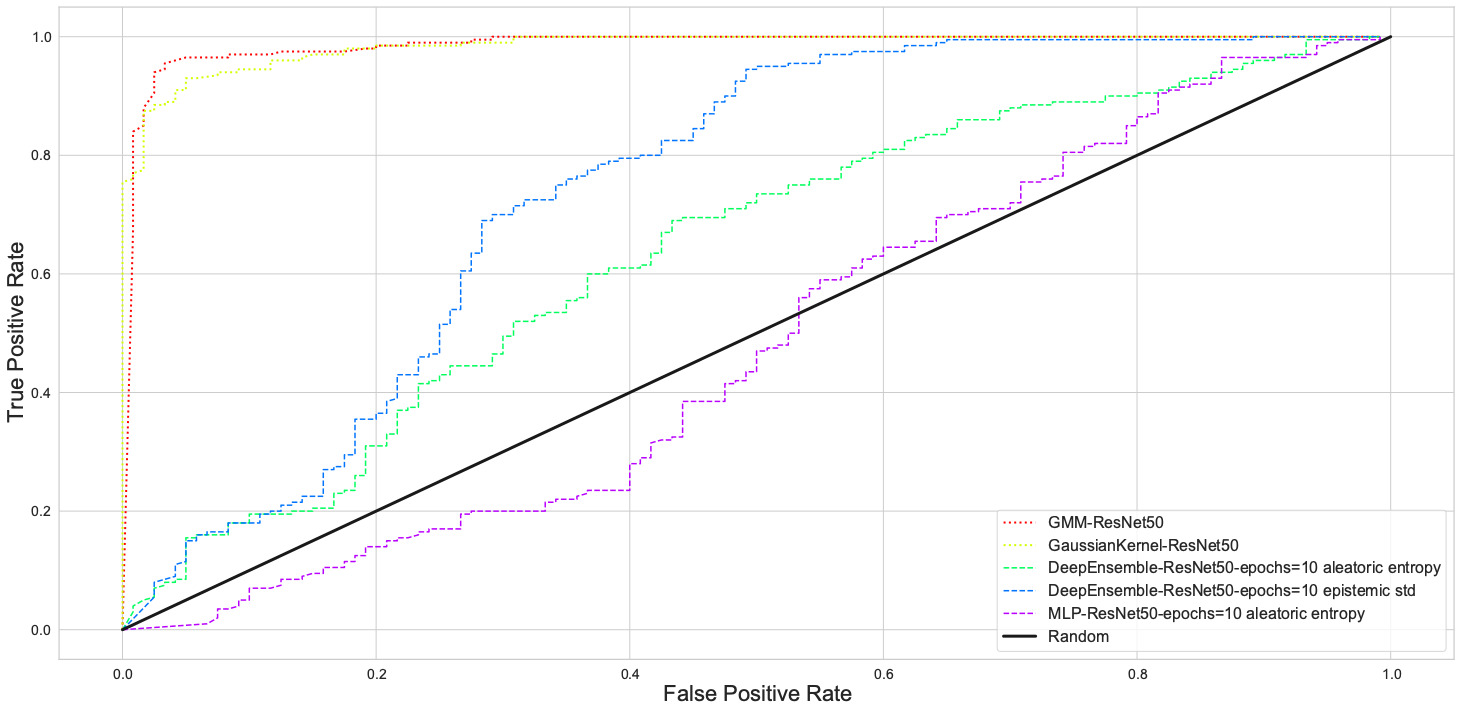

In [84]:
Figures.roc(Data.sel_keys(values_novel, "ResNet50"), "linear")

We conduct the same procedure with ambiguous images.

In [87]:
values_ambiguous = PerformanceMetrics.uncertainty_classification(models, z_iid, z_ambiguous, verbose = False)

../common/figures.py:442: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


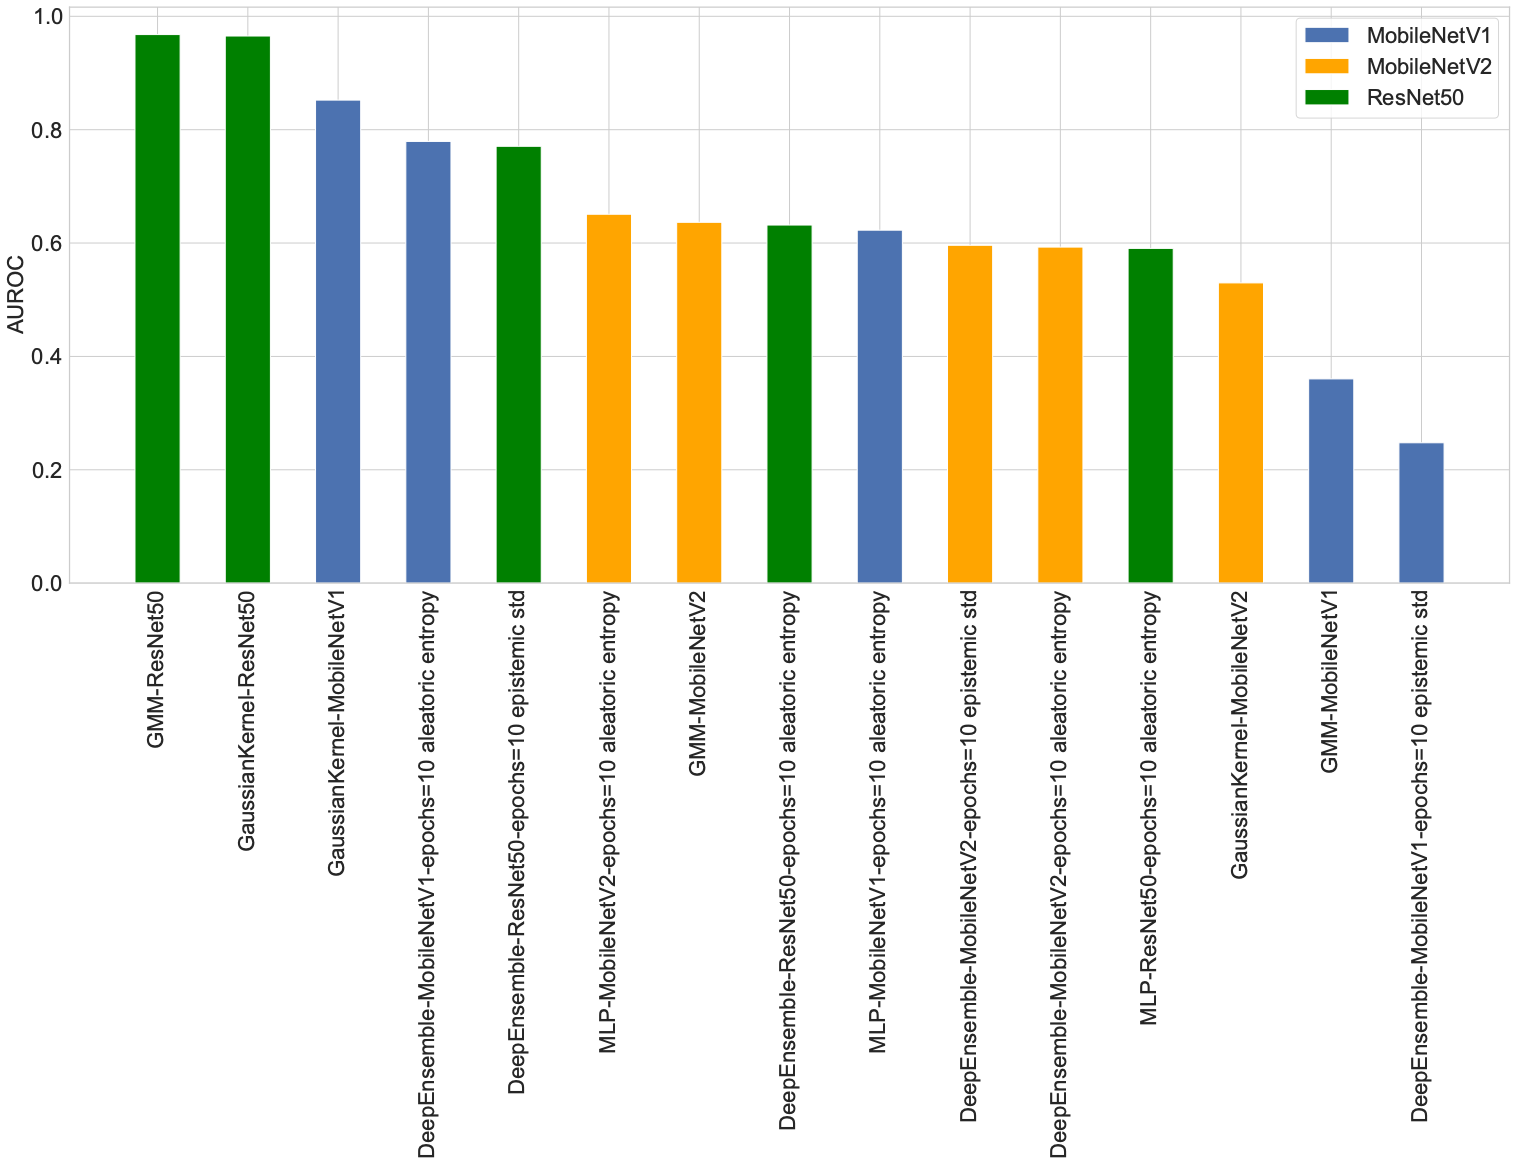

In [88]:
Figures.auroc(PerformanceMetrics.AUROC(values_ambiguous))

**Observations**: We have similar results as before. Now, we try to distinnguish novel from ambiguous images:

We now plot different histogram representing the distribution of "classifiable", "ambiguous" or "novel" data for the best four techniques.

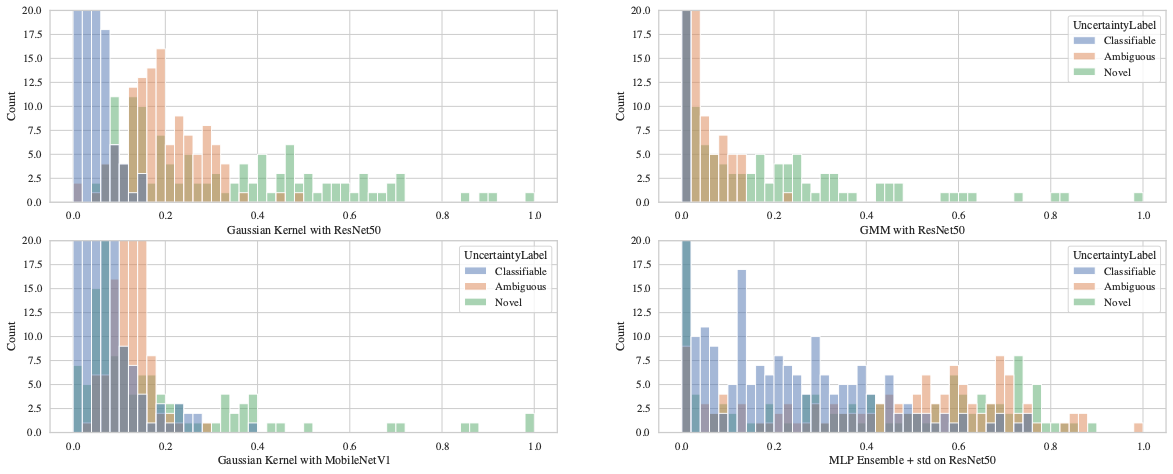

In [115]:
strategy_names = list(uncertainty_scaled.keys())
strategy_names = [  strategy_names[5], strategy_names[4], strategy_names[1],  strategy_names[13]]
strategy_names
Figures.histogram(uncertainty_scaled, model_names = strategy_names, figsize= (20,12))
